# Guia do Projeto - Tech Challenge Fase 4 - Parte 03

## Análise de Emoções com DeepFace

Já conseguimos detectar *onde* estão as pessoas (Parte 02). Agora, queremos entender *como* elas estão se sentindo. Para isso, utilizaremos a biblioteca **DeepFace**.

### Teoria: As 7 Emoções Básicas

A maioria dos modelos de reconhecimento de emoção (incluindo o DeepFace) baseia-se na teoria de **Paul Ekman**, que identificou 7 emoções universais que são expressas da mesma forma em qualquer cultura:

1.  **Raiva (Angry)**
2.  **Medo (Fear)**
3.  **Neutro (Neutral)** - (Adicionada posteriormente como estado base)
4.  **Tristeza (Sad)**
5.  **Desgosto (Disgust)**
6.  **Felicidade (Happy)**
7.  **Surpresa (Surprise)**

### Como funciona o DeepFace?

O DeepFace é um framework que encapsula vários modelos de Deep Learning (como VGG-Face, Google FaceNet, etc.). Para emoção, ele analisa a geometria facial (curvatura da boca, abertura dos olhos, sobrancelhas) e classifica a imagem em uma dessas 7 categorias.

**O Processo:**
1.  **Recorte (Cropping):** Pegamos apenas o rosto detectado pelo YOLO.
2.  **Análise:** O DeepFace processa esse recorte.
3.  **Dominância:** O modelo retorna a probabilidade de todas as emoções. Nós escolhemos a "dominante" (a mais provável).

In [5]:
import cv2
import sys
import os
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Optional, Generator, Tuple
from ultralytics import YOLO
from deepface import DeepFace
import logging
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### 1. Reutilizando Classes Anteriores

Novamente, trazemos nossas classes `VideoProcessor` e `FaceDetector` para garantir que este notebook funcione sozinho.

In [6]:
# --- Classes de Suporte (Copiadas das Partes 01 e 02) ---

@dataclass
class BoundingBox:
    x: int
    y: int
    width: int
    height: int

@dataclass
class FaceDetection:
    bounding_box: BoundingBox
    confidence: float

class VideoProcessor:
    def __init__(self, video_path: str):
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Arquivo de vídeo não encontrado: {video_path}")
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

    def get_frames(self) -> Generator[Tuple[int, float, cv2.Mat], None, None]:
        frame_num = 0
        while True:
            ret, frame = self.cap.read()
            if not ret: break
            timestamp = frame_num / self.fps if self.fps > 0 else 0
            yield frame_num, timestamp, frame
            frame_num += 1
    
    def release(self):
        self.cap.release()

class FaceDetector:
    def __init__(self, model_path: str = "yolo11n-pose.pt", confidence_threshold: float = 0.5):
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold

    def detect(self, frame) -> List[FaceDetection]:
        results = self.model(frame, conf=self.confidence_threshold, verbose=False)
        faces = []
        frame_height, frame_width = frame.shape[:2]

        for result in results:
            if result.keypoints is None: continue
            keypoints = result.keypoints.data
            for person_keypoints in keypoints:
                # Simplificação: Usando apenas a caixa delimitadora dos keypoints com padding
                # Em produção, usaríamos a lógica completa da Parte 02
                face_keypoints = person_keypoints[:3] # Nariz e olhos
                if face_keypoints[0][2] > 0.5: # Se nariz visível
                     # Lógica simplificada para demonstração
                     x_min = int(face_keypoints[:, 0].min())
                     y_min = int(face_keypoints[:, 1].min())
                     x_max = int(face_keypoints[:, 0].max())
                     y_max = int(face_keypoints[:, 1].max())
                     
                     w = x_max - x_min
                     h = y_max - y_min
                     pad = int(w * 0.5)
                     
                     faces.append(FaceDetection(
                         bounding_box=BoundingBox(
                             x=max(0, x_min - pad), 
                             y=max(0, y_min - pad), 
                             width=w + 2*pad, 
                             height=h + 2*pad
                         ),
                         confidence=0.9
                     ))
        return faces

### 2. O Analisador de Emoções

Aqui criamos a classe `EmotionAnalyzer`. Ela recebe um frame e uma lista de rostos detectados, recorta cada rosto e pede ao DeepFace para analisá-lo.

In [7]:
@dataclass
class EmotionAnalysis:
    emotion: str
    confidence: float

class EmotionAnalyzer:
    """
    Responsável por inferir a emoção a partir de um recorte de rosto.
    """
    def __init__(self):
        # O DeepFace carrega os modelos na primeira execução
        print("Inicializando DeepFace (isso pode demorar um pouco na primeira vez)...")

    def analyze(self, frame: np.ndarray, faces: List[FaceDetection]) -> List[EmotionAnalysis]:
        emotions = []
        for face in faces:
            # 1. Recortar o rosto (ROI - Region of Interest)
            bbox = face.bounding_box
            x, y = max(0, bbox.x), max(0, bbox.y)
            # Garantir que não saia da imagem
            x_end = min(frame.shape[1], x + bbox.width)
            y_end = min(frame.shape[0], y + bbox.height)
            
            face_img = frame[y:y_end, x:x_end]
            
            # Se o recorte for inválido (vazio), ignora
            if face_img.size == 0:
                emotions.append(EmotionAnalysis(emotion="unknown", confidence=0.0))
                continue

            try:
                # 2. Análise com DeepFace
                # enforce_detection=False porque já detectamos o rosto com YOLO
                result = DeepFace.analyze(
                    img_path=face_img,
                    actions=['emotion'],
                    enforce_detection=False,
                    detector_backend='skip', # Pula a detecção interna
                    silent=True
                )
                
                # O resultado é uma lista, pegamos o primeiro item
                if isinstance(result, list): result = result[0]
                
                dominant_emotion = result['dominant_emotion']
                # A confiança vem em porcentagem (0-100), normalizamos para 0-1
                confidence = result['emotion'][dominant_emotion] / 100.0
                
                emotions.append(EmotionAnalysis(emotion=dominant_emotion, confidence=confidence))
                
            except Exception as e:
                # Se o DeepFace falhar (rosto muito pequeno, desfocado), retornamos neutro/desconhecido
                print(f"Erro DeepFace: {e}")
                emotions.append(EmotionAnalysis(emotion="unknown", confidence=0.0))
                
        return emotions

### 3. Teste Prático

Vamos rodar o analisador em um frame específico e visualizar o resultado.

Inicializando DeepFace (isso pode demorar um pouco na primeira vez)...


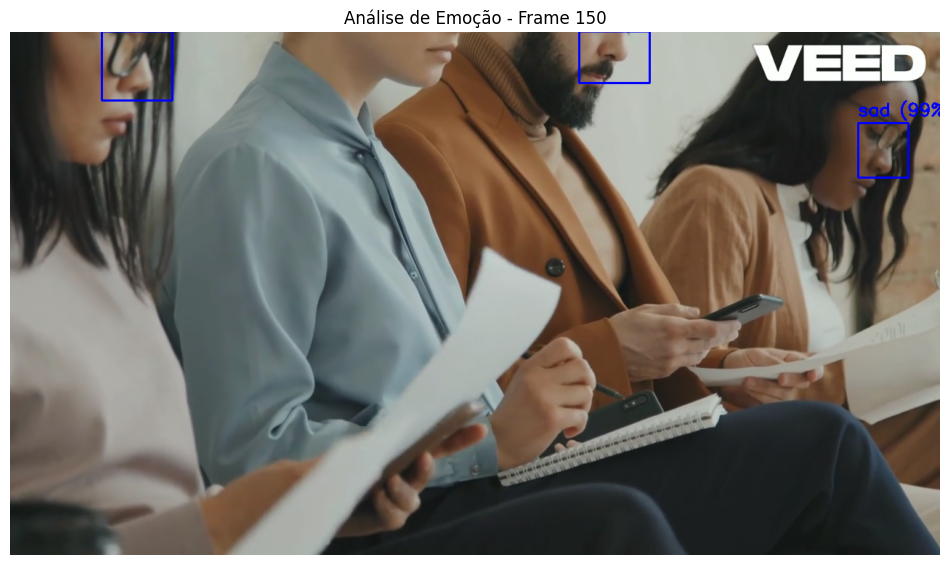

In [8]:
video_path = "meu_video.mp4"

try:
    processor = VideoProcessor(video_path)
    detector = FaceDetector()
    analyzer = EmotionAnalyzer()

    # Pegar um frame onde sabemos que há ação (ex: frame 150)
    target_frame = 150
    
    for frame_num, ts, frame in processor.get_frames():
        if frame_num == target_frame:
            # 1. Detectar
            faces = detector.detect(frame)
            
            # 2. Analisar Emoção
            emotions = analyzer.analyze(frame, faces)
            
            # 3. Visualizar
            img_viz = frame.copy()
            for i, face in enumerate(faces):
                bbox = face.bounding_box
                emotion = emotions[i]
                
                # Desenha caixa
                cv2.rectangle(img_viz, (bbox.x, bbox.y), (bbox.x+bbox.width, bbox.y+bbox.height), (255, 0, 0), 2)
                
                # Escreve emoção
                label = f"{emotion.emotion} ({emotion.confidence:.0%})"
                cv2.putText(img_viz, label, (bbox.x, bbox.y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
            
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(img_viz, cv2.COLOR_BGR2RGB))
            plt.title(f"Análise de Emoção - Frame {target_frame}")
            plt.axis('off')
            plt.show()
            break
            
    processor.release()

except Exception as e:
    print(f"Erro: {e}")

### Conclusão da Parte 03

A integração do **YOLO** (para encontrar o rosto) com o **DeepFace** (para classificar a emoção) cria um pipeline robusto. 

**Nota Importante:** A análise de emoção é sensível à qualidade da imagem. Rostos muito pequenos, borrados ou em ângulos extremos podem gerar resultados imprecisos ("unknown" ou confiança baixa). Por isso, o pré-processamento e a estabilização da detecção facial (Parte 02) são tão importantes.